<a href="https://colab.research.google.com/github/snaby/quantum-ising-model/blob/master/Transverse_Field_Quantum_Ising_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Abstract

This notebook investigates the physics of a 1D closed chain of spin 1/2 particles, specifically a chain with $L = 2$ sites. The total dimension of the Hilbert Space is $2^{L} = 4$ dimensions. The mathematical model used to study this physical system is the transverse-field Quantum Ising model. The method of analysis involves: (i) diagonalization of the hamiltonian; (ii) implementing an MCMC algorithm to compute a numerical average of the energy. By using MCMC I obtained a numerical expectation value of the energy, $E$ (see Results code below for value). The theoretical value according to the Boltzmann probability is $-2.69541682108681$. 



# Physical System and Model

In project 3, we studied the classical Ising Model on a 2D $L$ $\times$ $L$ lattice. When more than one spin is present, they may interact. In the absence of a magnetic field, the model is characterized by the following spin interaction energy: 

\begin{equation}
E = - \sum_{\langle i,j\rangle}s_is_j 
\end{equation}

However, it is also often interesting to subject the system to an external magnetic field $h$ and analyze the behavior of the magnetization as $h$ is varied. The energy then acquires an extra term:

\begin{equation}
E= - \sum_{\langle i,j\rangle}s_is_j - h\sum_i s_i,
\end{equation}

In analogy with its classical counterpart, I wish to explore the 1D closed chain of two-state systems,such as spin 1/2 particles, with a specified transverse field. 
The mathematical model I will use to study this physical system is the transverse-field Quantum Ising model which can be described with the following Hamiltonian:

\begin{equation}
\hat{H} = - J \sum_{\langle i,j\rangle} \hat \sigma_{i}^{z} \hat\sigma_{j}^{z} - h \sum_{i} \hat\sigma_{i}^{x}
\end{equation}

where $\langle i,j\rangle$ implies a summation over all nearest-neighbour pairs, $\hat{\sigma}_{i(j)}^{z}$  and $\hat{\sigma}_{i}^{x}$ are the Pauli matrices and acts only on the spin placed on site $i \space (j)$, $h$ is the magnitude of the magnetic field, and $J$ is the exchange energy. For this project, $J = 1$ and let's assume that only nearest-neighbor interaction exists, so $j$ = $i$ + 1. Since the chain is closed, this induces peridocity of the chain. Periodicity of the chain means that if the chain configuration is represented as an array $s_{i}$ of spins

\begin{align}
    \begin{pmatrix}
        s_{0} & \cdots & s_{L-1} \\
    \end{pmatrix}
\end{align}

Then the nearest neighbors of a spin on the edge are identified by "wrapping the chain around" to the opposite edge. For example, for spin $s_{0}$ on the left edge of the chain, the nearest neighbor on the left would be $s_{L - 1}$, a spin that is on the right edge of the chain. 

# Algorithms 

The first step in preparing my code for the Hamiltonian matrix is to write the basis. For this, I denote the
up-spin with the number ‘1’ and the down-spin with the number ‘0’. Each different sequence of zeros and ones defines a basis
vector. The total dimension of the Hilbert space for a spin-1/2 chain with $L$ sites is $2^{L}$. As stated above, I will be focusing on a $4$ dimensional Hilbert space, $L=2$. 

After writing the basis, I can now construct the Hamiltonian matrix. In the absence of a transverse magnetic field, $\hat{H}$ is a diagonal matrix with diagonal terms consisting of the ising interaction energy: 

\begin{align}\\
    \hat{H}_{unperturbed}= \begin{pmatrix}
        <00|\hat{H}|00>  & 0 & 0 & 0 \\\\
        0 & <01|\hat{H}|01> & 0 & 0 \\\\
        0  & 0 & <10|\hat{H}|10> & 0 \\\\
        0 & 0 & 0& <11|\hat{H}|11> \\\\
    \end{pmatrix}\\\\
\end{align}


When we subject our system to a transverse magnetic field, this causes mixing of states. In this case, the mixed states are the ones in which the bra and ket are off by only one digit. As a result, $\hat{H}$ is no longer diagonal and our problem resorts to diagonalizing:


\begin{align}\\
    \hat{H} =\begin{pmatrix}
        <00|\hat{H}|00>  & <00|\hat{H}|01> & <00|\hat{H}|10> & 0 \\\\
        <01|\hat{H}|00> & <01|\hat{H}|01> & 0 &<01|\hat{H}|11> \\\\
        <10|\hat{H}|00>  & 0 & <10|\hat{H}|10> & <10|\hat{H}|11>\\\\
        0 & <11|\hat{H}|01> & <11|\hat{H}|10 >& <11|\hat{H}|11> 
    \end{pmatrix}\\\\
\end{align} 


After I have the full Hamiltonian matrix, my problem reduces to using direct diagonalization in order to get the eigenvalues and eigenvectors. 

With the eigenvalues and eigenstates computed, I then: (i) will take a "random walk" through these states characterized by the eigenstates using MCMC; (ii) keep track of the average energy at each state. Each eigenstate is weighted according to the Boltzmann probability 

\begin{equation}\\
P_i =\frac{exp{[-E_i/\beta]}}{Z}\\
\end{equation}

where $\beta$ = $k_BT$, $E_i$ is the energy eigenvalue of state $i$, and $Z$ is the partition function defined as:

\begin{equation}\\
Z =\sum_i{exp{[-E_i/\beta]}}\\
\end{equation} 

# Functions for Constructing the Hamiltonian Matrix

In [ ]:
def binary(L, output_type = 'binary'):
  """ Enumerates all possible sequences of zeros and ones that define a basis vector

  Args:
      L(int): The length of the chain

  Kwargs: 
      output_type(str): outputs a binary representation of each basis vector (default) or a non-binary representation
      where each instance of 0 is replaced by -1 

  Returns:
     basis(arr): all possible sequences of zeros(or -1) and ones that define a basis vector given a length L.
  """
  
  basis = np.zeros([2**L, L])
  for k in range(2**L):
    m = k 
    for j in range(L):
      basis[k][j] = int(m/(2**(L-1-j)))
      m = m - int(m/(2**(L-1-j))) * 2**(L-1-j)
  if output_type == 'binary': 
    return basis
  if output_type == 'nobinary':
    for i in range(2**L):
      for j in range(L):
        if basis[i][j] == 0: 
          basis[i][j] = -1
    return basis

L = 2
basis = binary(L)
recoded_basis = binary(L, output_type = 'nobinary')

def sigma_x(oldstate):
  """ Outputs all arrays that are off by only one digit from the input array. 

  Args:
      oldstate(arr): Array given in the non-binary representation

  Returns:
     new_state(arr): List of arrays that are off by only digit from oldstate. Output type is in the binary representation
     in order to compute its decimal value
  """
  new_state = np.zeros([L,L])
  for i in range(L):
    new_state[i, :] = oldstate
    new_state[i, i] *= -1
  for i in range(L):
    for j in range(L):
      if new_state[i][j] == -1: 
          new_state[i][j] = 0
  return (new_state)

def H(L):
  """ Builds the Hamiltonian matrix using the transverse field Quantum Ising Model

  Args:
      L(int): Length of the chain

  Returns:
     H.T(arr): Transpose of the Hamiltonian matrix
  """
  H = np.zeros([2**L, 2**L])
  h = 1
  for i in range (2**L):
    x = []
    for j in range(L):
      x.append(recoded_basis[i, j] * recoded_basis[i, (j+1)%L])
    ising_energy = np.sum(x) * -1
    H[i][i] = ising_energy  
    H[0, 2] = h
    H[0, 1] = h
    H[1, 3] = h
    H[1, 0] = h
    H[2, 0] = h
    H[2, 3] = h
    H[3, 1] = h
    H[3, 2] = h
  return(H.T)
H_matrix = H(L)
H_matrix;

In [ ]:
print(basis[0])
print(sigma_x(recoded_basis[0]))

[0. 0.]
[[1. 0.]
 [0. 1.]]


In [ ]:
print(basis[1])
print(sigma_x(recoded_basis[1]))

[0. 1.]
[[1. 1.]
 [0. 0.]]


In [ ]:
print(basis[2])
print(sigma_x(recoded_basis[2]))

[1. 0.]
[[0. 0.]
 [1. 1.]]


In [ ]:
print(basis[3])
print(sigma_x(recoded_basis[3]))

[1. 1.]
[[0. 1.]
 [1. 0.]]


In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(H_matrix)
eigenvalues, eigenvectors;

#Functions for MCMC algorithm

In [ ]:
def MCMC(n, beta, output_type = 'float'):
  """ Solves for the expectation value of the energy using the Metropolis MCMC simulation 

  Args:
      n(int): the number of "walks" through the configurations/states

  Kwargs: 
      output_type(str): outputs the last element (default) or the whole array 

  Returns:
     running_avg: average energy per walk using Metropolis MCMC simulation 
  """

  current_state = 0 
  running_avg = np.zeros(n)
  weight = [np.exp(-beta*eigenvalues[0]), np.exp(-beta*eigenvalues[1]), np.exp(-beta*eigenvalues[2]), np.exp(-beta*eigenvalues[3])] #using this as a building block to construct the ratio for acceptance
  H = [eigenvalues[0], eigenvalues[1], eigenvalues[2], eigenvalues[3]]

  for i in range (1, n):
    proposed_state = np.random.choice([0, 1, 2, 3]) #0-3 represents a different configuration/eigenstate
    p_accept = np.min([1, weight[proposed_state]/weight[current_state]])
    r = np.random.uniform(0,1)
    if r <= p_accept: 
      current_state = proposed_state
    running_avg[i] = running_avg[i-1] + (1/(i))*(H[current_state] - running_avg[i-1])
  if output_type == 'float':
    return running_avg[-1]
  if output_type == 'array':
    return running_avg

def average_energy(beta):
  """ Solves for the expectation value of the energy exactly according to the Boltzmann probability

  Args:
      beta(int): The Boltzmann constant times the absolute temperature

  Returns:
     E: Expectation value of the energy
  """
  Z =  np.exp(-beta*eigenvalues[0]) + np.exp(-beta*eigenvalues[1])+ np.exp(-beta*eigenvalues[2])+ np.exp(-beta*eigenvalues[3])
  E = (np.exp(-beta*eigenvalues[0])/Z) * eigenvalues[0]  + (np.exp(-beta*eigenvalues[1])/Z) * eigenvalues[1] + (np.exp(-beta*eigenvalues[2])/Z) * eigenvalues[2] + (np.exp(-beta*eigenvalues[3])/Z) * eigenvalues[3]
  return E

# Results
From the code cell below, we see that the numerical value for the expectation value of the energy is around $-2.6970021938518456$. As a sanity check, I computed the expectation value of the energy exactly according to the Boltzmann probability. The ensemble average of the energy given by

\begin{equation}
<E> =\sum_iP_iE_i 
\end{equation}

where $P_i$ is 

\begin{equation}
P_i =\frac{exp{[-E_i/\beta]}}{Z}\\\\
\end{equation}
and $E_i$ is the energy configuration of state $i$. Following this, I got $E$ = $-2.69541682108681$ which is very close to the numerical value I got. 

In [ ]:
print('The numerical value for the expectation energy is' , MCMC(1000, 2, output_type = 'float'))
print('The analytic value for the expectation energy is' , average_energy(2))

The numerical value for the expectation energy is -2.6970021938518456
The analytic value for the expectation energy is -2.69541682108681


# Plot of Analytic vs Numerical $<E>$ per "walk"

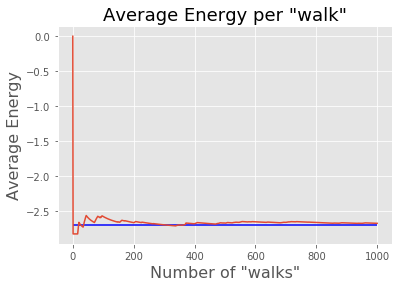

In [ ]:
x = MCMC(1000, 2, output_type = 'array')
xrange = np.linspace(0, 1000, len(x))
plt.plot(xrange, x)
plt.title('Average Energy per "walk"', fontsize = 18)
plt.xlabel('Number of "walks"', fontsize = 16)
plt.ylabel('Average Energy', fontsize = 16)
plt.hlines(average_energy(2), 0, 1000, color = 'blue')

# References

(i) https://www.cond-mat.de/events/correl13/manuscripts/wessel.pdf